**Initialize our VAE**

In [186]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.base.vae import AE
from scCFM.models.plotting_utils.sc_umap import umap
from scCFM.models.utils import get_distribution

from scvi.distributions import NegativeBinomial

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

## Analysis in the latent space

**Helper functions**

In [187]:
def linear_interpolation(p0, p1, n_steps=100):
    if len(p0.shape) == 1:
        p0 = p0.unsqueeze(0)
        p1 = p1.unsqueeze(0)
    alpha = torch.linspace(0, 1, steps=n_steps).view(-1,1)
    interp = alpha*p0 + (1-alpha)*p1
    return interp

In [188]:
def joint_adata(adata, trajectory, indices, is_csr=False):
    # Concatenate the anchor points, spline_trajectory, and existing latent points
    if is_csr:
        all_points = np.vstack([adata.X.A, trajectory.numpy()])
    else:
        all_points = np.vstack([adata.X, trajectory.numpy()])
    
    # Create a new AnnData object for the combined data
    is_trajectory = ["False" for _ in range(len(adata))] + ["True" for _ in range(len(trajectory))]
    obs = pd.DataFrame(is_trajectory)
    obs.columns = ["is_trajectory"]

    end_points = ['True' if i in indices else 'False' for i in range(all_points.shape[0])]
    obs["is_end_point"] = end_points

    combined_adata = sc.AnnData(X=all_points,
                                obs=obs)
    projected_new = trajectory.detach().numpy().dot(adata.varm["PCs"])
    combined_adata.obsm["X_pca"] = np.concatenate([adata.obsm["X_pca"],
                                                 projected_new], axis=0)
    # Compute UMAP coordinates for the combined data
    sc.pp.neighbors(combined_adata)
    sc.tl.umap(combined_adata)
    return combined_adata

In [22]:
def sample_point_based_on_pca_condition(X_pca, x_condition, y_condition):
    X_pca_valid_idx = np.arange(len(X_pca))[np.logical_and(x_condition, y_condition)]
    idx = np.random.choice(X_pca_valid_idx)
    return idx

**Analysis**

In [23]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_key': 'experimental_time', 
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [0.8, 0.2],
            'batch_size': 256, 'num_workers': 2}

model_config = {'likelihood': 'nb', 
                  'dropout': False, 
                  'dropout_p': False, 
                  'hidden_dims': [512, 256, 64], 
                  'batch_norm': False, 
                  'model_log_library_size': True, 
               }

In [24]:
# Initialize datamodule
datamodule = scDataModule(**datamodule)



# Initialize the model 
model = AE(in_dim = datamodule.in_dim,
            **model_config) 

In [25]:
model.load_state_dict(torch.load("/nfs/homedirs/pala/scCFM/notebooks/train_autoencoder/eb/models_ae/model_lib.ckpt")["state_dict"])

<All keys matched successfully>

In [26]:
# load anndata
adata_latents = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate_latents.h5ad")

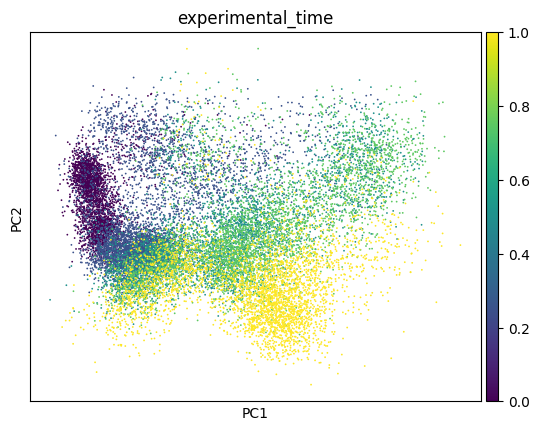

In [27]:
sc.pl.pca(adata_latents, color="experimental_time")

**Check stochastic manifold**

In [28]:
import stochman
from scCFM.models.manifold.statistical_manifold import scStatisticalManifold

In [29]:
manifold = scStatisticalManifold(model)

In [216]:
# Sample random pair of points 
random_points = False

indices = np.arange(adata_latents.X.shape[0])
if random_points:
    i0 = np.random.choice(indices)
    i1 = np.random.choice(indices)
else:
    i0 = sample_point_based_on_pca_condition(adata_latents.obsm["X_pca"], 
                                    adata_latents.obsm["X_pca"][:,0] > 2, 
                                    adata_latents.obsm["X_pca"][:,1] > 2)
    i1 = sample_point_based_on_pca_condition(adata_latents.obsm["X_pca"], 
                                    adata_latents.obsm["X_pca"][:,0] < 1, 
                                    adata_latents.obsm["X_pca"][:,1] < -2)

i0, i1 = 8721, 1141

p0 = torch.from_numpy(adata_latents.layers["X_latents"][i0])
p1 = torch.from_numpy(adata_latents.layers["X_latents"][i1])

adata_latents.obs["is_end_point"] = ['True' if i in [i0, i1] else 'False' for i in range(adata_latents.shape[0])]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


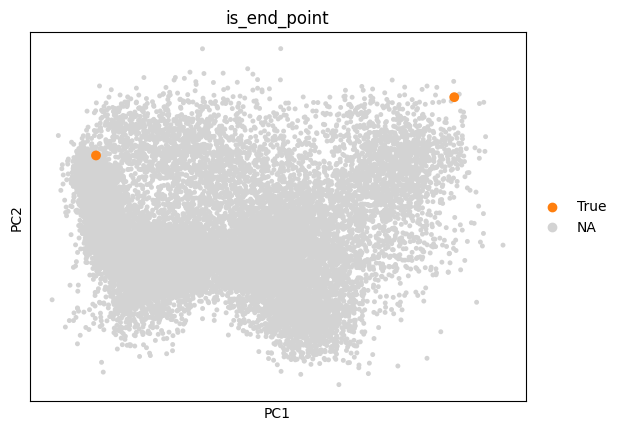

In [217]:
sc.pl.pca(adata_latents, color=["is_end_point"], 
         size=np.where(adata_latents.obs['is_end_point'] == "True", 200, 50), 
         groups="True")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


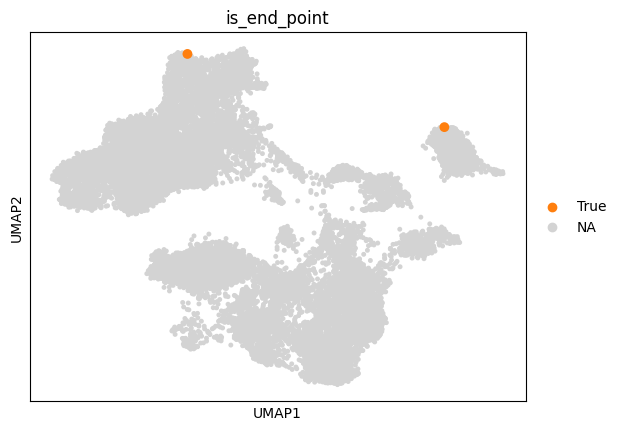

In [218]:
sc.pl.umap(adata_latents, 
                color=[ "is_end_point"],
                groups="True",
                size=np.where(adata_latents.obs['is_end_point'] == "True", 200, 50))

Spline

In [248]:
spline, losses = manifold.connecting_geodesic(p0,
                                               p1,
                                               library_size=torch.tensor(800),
                                               max_iter=5000,
                                               eval_grid=100, 
                                               lr=1e-1,
                                               minimize_energy=True, 
                                               return_losses=True
                                              )

/nfs/homedirs/pala/scCFM/scCFM/models/manifold/geodesic.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  library_size = torch.tensor(library_size)


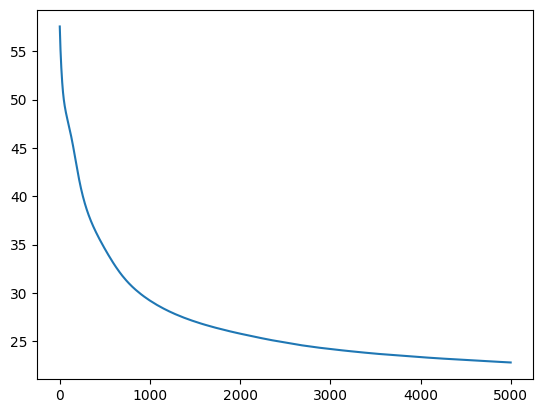

In [249]:
plt.plot(losses)

In [250]:
alpha = torch.linspace(0, 1, 100, dtype=spline.begin.dtype, device=spline.device)
manifold_points = spline(alpha)
manifold_points = manifold_points.detach()

In [251]:
manifold_points

tensor([[  0.1106,  -3.4330,  -1.5676,  ..., -14.8666,   8.3050,   5.5637],
        [  0.0267,  -3.4305,  -1.6793,  ..., -14.7738,   8.0296,   5.7289],
        [ -0.0182,  -3.3933,  -1.7996,  ..., -14.6758,   7.7498,   5.8950],
        ...,
        [  2.9101,  -2.7154,   3.0713,  ...,   7.0514,   2.1804,   3.1309],
        [  2.7870,  -2.6829,   3.1496,  ...,   7.0832,   2.2268,   3.1129],
        [  2.7050,  -2.6207,   3.2155,  ...,   7.1138,   2.2622,   3.1094]])

Linear interpolation

In [252]:
linear_points = linear_interpolation(p1, p0, n_steps=100)

In [253]:
linear_points

tensor([[  0.1106,  -3.4330,  -1.5676,  ..., -14.8666,   8.3050,   5.5637],
        [  0.1368,  -3.4248,  -1.5192,  ..., -14.6446,   8.2440,   5.5389],
        [  0.1630,  -3.4166,  -1.4709,  ..., -14.4226,   8.1829,   5.5141],
        ...,
        [  2.6526,  -2.6371,   3.1189,  ...,   6.6697,   2.3842,   3.1590],
        [  2.6788,  -2.6289,   3.1672,  ...,   6.8917,   2.3232,   3.1342],
        [  2.7050,  -2.6207,   3.2155,  ...,   7.1138,   2.2622,   3.1095]])

**Check trajectory embeddings on manifold**

In [254]:
combined_adata_manifold = joint_adata(adata_latents, manifold_points, (i0,i1))

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


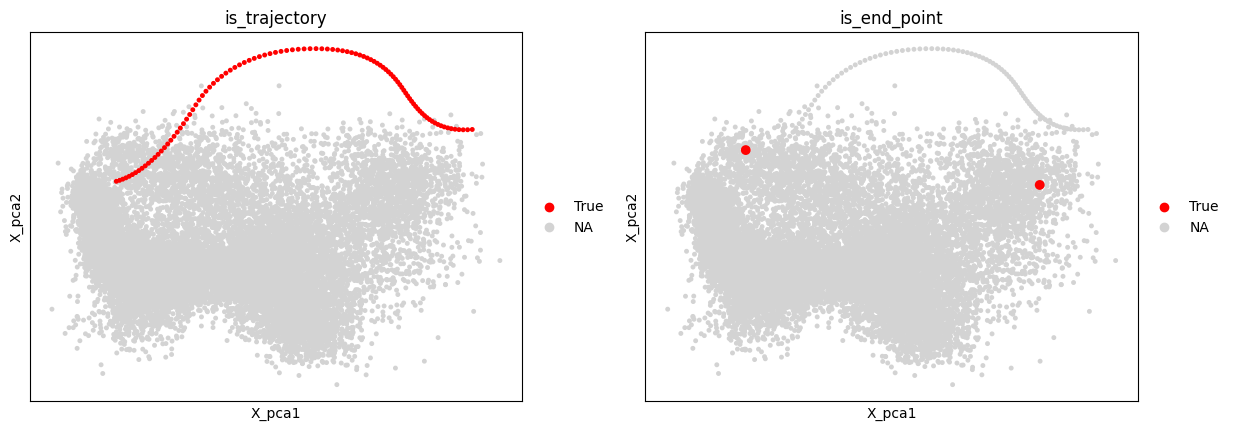

In [255]:
sc.pl.embedding(combined_adata_manifold, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_manifold.obs['is_end_point'] == "True", 200, 50),
               groups="True")

**Check trajectory embeddings on linear**

In [256]:
combined_adata_linear = joint_adata(adata_latents, linear_points, (i0,i1))

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


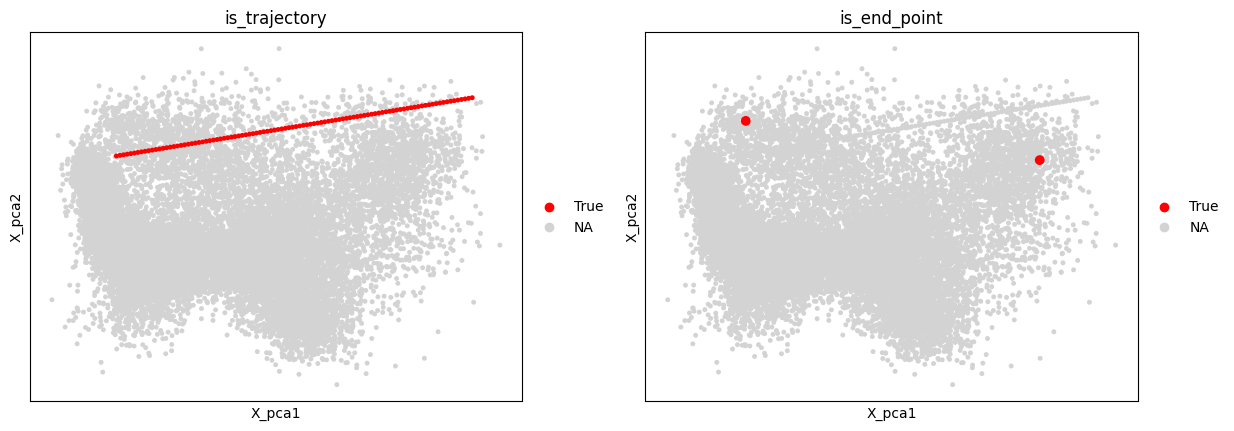

In [257]:
sc.pl.embedding(combined_adata_linear, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_linear.obs['is_end_point'] == "True", 200, 50),
               groups="True")

## Analysis in the data space

In [258]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad")

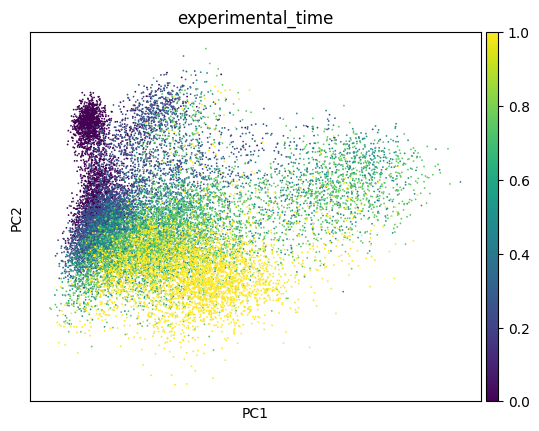

In [259]:
sc.pl.pca(adata, color="experimental_time")

In [260]:
def decode_trajectory(trajectory, 
                     model):
    with torch.no_grad():
        decoder_output = model.decode(trajectory, library_size=None)
    return decoder_output

In [261]:
decoder_outputs_manifold = decode_trajectory(manifold_points,
                 model)

In [262]:
decoder_outputs_linear = decode_trajectory(linear_points,
                 model)

Deterministic mean

In [263]:
mu_manifold = decoder_outputs_manifold["mu"].detach()
mu_linear = decoder_outputs_linear["mu"].detach()

Samples

In [264]:
nb_manifold = get_distribution(decoder_outputs_manifold, model.theta, likelihood = "nb")
nb_linear = get_distribution(decoder_outputs_linear, model.theta, likelihood = "nb")

nb_samples_manifold = nb_manifold.sample()
nb_samples_linear = nb_linear.sample()

In [265]:
combined_adata_decoded_manifold = joint_adata(adata, torch.log(1+mu_manifold), (i0,i1), is_csr=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [266]:
combined_adata_decoded_linear = joint_adata(adata, torch.log(1+mu_linear), (i0,i1), is_csr=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


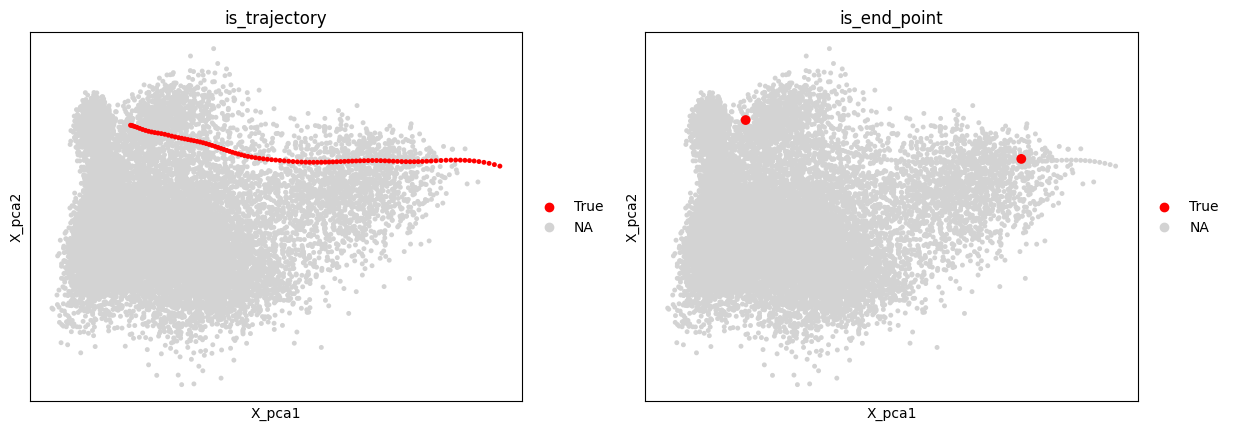

In [267]:
sc.pl.embedding(combined_adata_decoded_manifold, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_manifold.obs['is_end_point'] == "True", 200, 50),
               groups="True")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


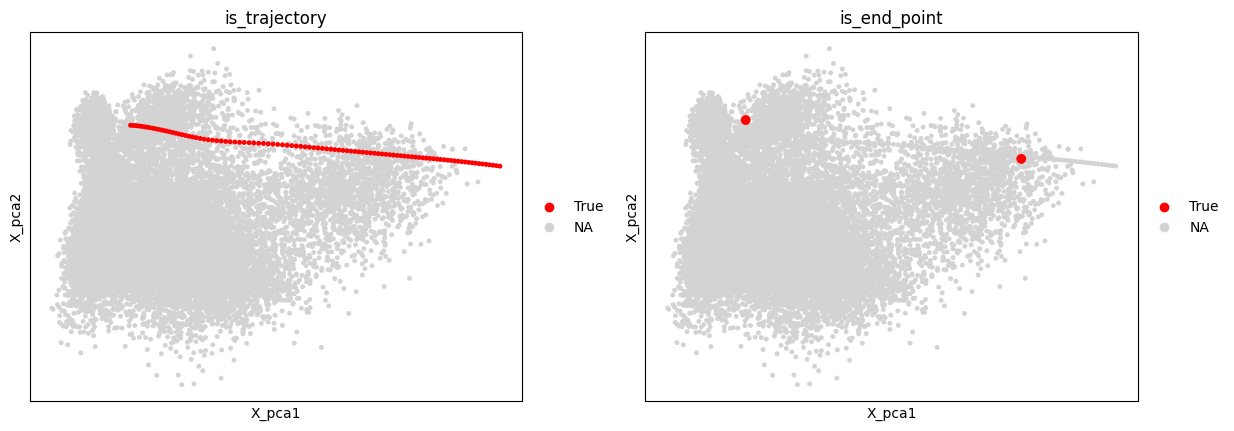

In [268]:
sc.pl.embedding(combined_adata_decoded_linear, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_manifold.obs['is_end_point'] == "True", 200, 50),
               groups="True")

In [269]:
combined_adata_decoded_sample_manifold = joint_adata(adata, torch.log(1+nb_samples_manifold), (i0,i1), is_csr=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [270]:
combined_adata_decoded_sample_linear = joint_adata(adata, torch.log(1+nb_samples_linear), (i0,i1), is_csr=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


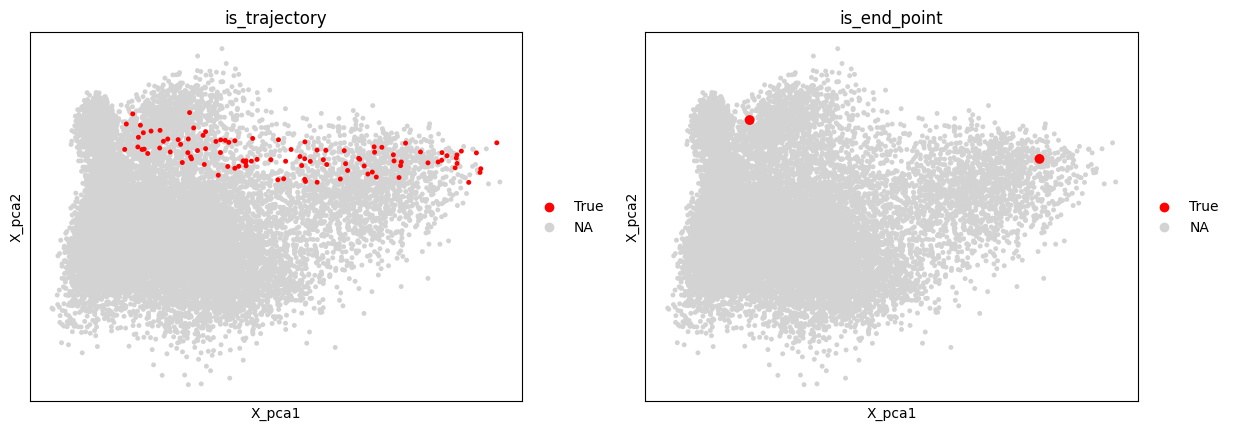

In [271]:
sc.pl.embedding(combined_adata_decoded_sample_manifold, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_manifold.obs['is_end_point'] == "True", 200, 50),
               groups="True")

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


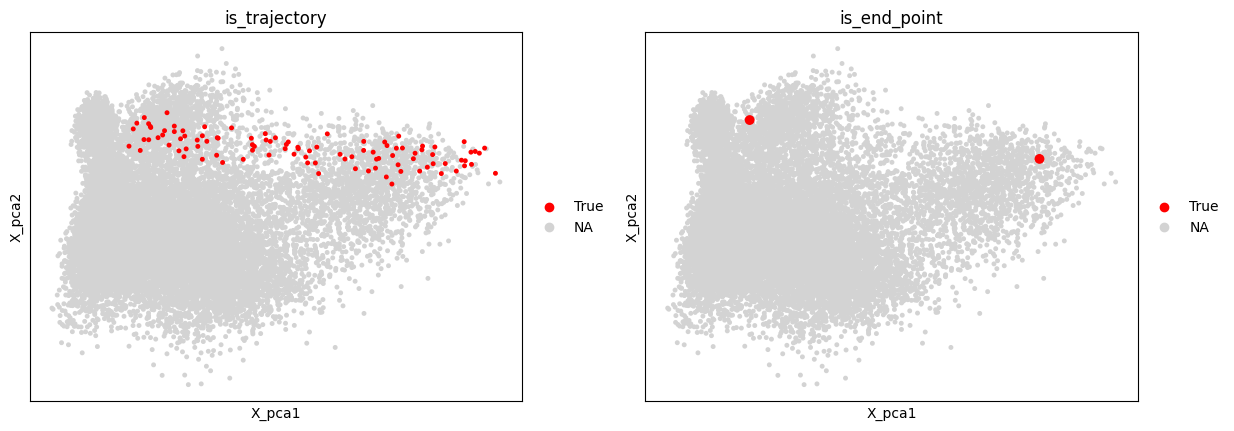

In [272]:
sc.pl.embedding(combined_adata_decoded_sample_linear, basis='X_pca', 
                color=["is_trajectory", "is_end_point"],
                palette={"True":"red", "False":"lightgrey"}, 
                size=np.where(combined_adata_manifold.obs['is_end_point'] == "True", 200, 50),
               groups="True")

In [277]:
nb_samples_manifold.max(1)

torch.return_types.max(
values=tensor([ 61., 117.,  92.,  85.,  73., 130., 112.,  86.,  98.,  66.,  57.,  54.,
         50.,  56.,  59.,  48.,  57.,  58.,  25.,  32.,  63.,  48.,  35.,  47.,
         28.,  35.,  37.,  37.,  53.,  52.,  46.,  28.,  27.,  29.,  33.,  34.,
         52.,  41.,  35.,  27.,  29.,  55.,  28.,  37.,  19.,  44.,  68.,  63.,
         43.,  46.,  33.,  36.,  29.,  61.,  35.,  31.,  25.,  31.,  29.,  23.,
         23.,  20.,  24.,  40.,  37.,  21.,  22.,  30.,  31.,  28.,  24.,  30.,
         21.,  33.,  31.,  20.,  22.,  32.,  25.,  19.,  30.,  23.,  29.,  34.,
         22.,  26.,  23.,  28.,  27.,  33.,  29.,  25.,  34.,  26.,  42.,  25.,
         29.,  40.,  34.,  26.]),
indices=tensor([ 402,  402,  402,  406,  402,  402,  659,  402,  402,  406,  406,  685,
         406,  406,  685,   10,  601,  659,    8,  685,  685,  406,  406,  685,
         685,  685,  601,  685,  601,  685,  601,  685,  659,    8,    8,  685,
         685,  685,    8,  659,    8,  685,  40

In [278]:
nb_samples_linear.max(1)

torch.return_types.max(
values=tensor([100.,  77.,  86.,  46.,  78.,  93.,  85.,  46.,  68., 113.,  90.,  59.,
         80.,  61.,  54.,  60.,  58.,  42.,  60.,  44.,  48.,  72.,  37.,  46.,
         45.,  74.,  41.,  53.,  37.,  44.,  48.,  34.,  28.,  34.,  45.,  36.,
         44.,  38.,  32.,  34.,  40.,  41.,  35.,  36.,  30.,  26.,  34.,  34.,
         31.,  28.,  38.,  26.,  30.,  31.,  28.,  34.,  32.,  47.,  36.,  39.,
         34.,  34.,  36.,  50.,  30.,  28.,  26.,  37.,  23.,  23.,  43.,  27.,
         30.,  40.,  28.,  29.,  31.,  46.,  30.,  27.,  58.,  42.,  27.,  30.,
         50.,  44.,  39.,  41.,  29.,  33.,  50.,  24.,  24.,  38.,  33.,  44.,
         36.,  38.,  30.,  39.]),
indices=tensor([ 402,   38,  402, 1060,  406,  402,  406,  406,  402,  402,  402,  659,
         659,  406,    8,  601, 1143,  601,  659,  402,  406,  406,  405,  402,
         659,  406,  601,  965, 1144,  716,  406, 1143,   37,   10,  405,  405,
           8,    8,  965,  601,  601,  406,  71